## Test steerable canonicalization
In this notebook, we test the whether the steerable image canonicalizers can generate a canonical orientation properly for sample images. We also visualize the original and canonicalized images to see if the canonicalization is successful.

In [1]:
import torch
from torchvision import datasets, transforms
from equiadapt.images.canonicalization.continuous_group import SteerableImageCanonicalization
from equiadapt.images.canonicalization_networks import ESCNNSteerableNetwork
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from tqdm import tqdm

/home/mila/a/arnab.mondal/.conda/envs/equiadapt/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mila/a/arnab.mondal/escnn/escnn/group/groups/so3group.py:20: UserWarning: `py3nj` package not found! Will use a numerical method to compute the SO(3) Clebsh-Gordan coefficents. This is much slower but the coefficients will be cached on disk.
  warnings.warn("`py3nj` package not found! Will use a numerical method to compute the SO(3) Clebsh-Gordan coefficents. This is much slower but the coefficients will be cached on disk.")


### 1. Load the CIFAR-10 dataset
First load the dataset and the dataloader.

In [2]:
# Load the CIFAR10 dataset
train_transform = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.Resize(64),

                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(5),

                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                ])

test_transform = transforms.Compose([
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
            ])

# to visualize the original images
invert_normalize = transforms.Compose([
                transforms.Normalize(mean=(-0.4914/0.247, -0.4822/0.243, -0.4465/0.261), 
                                     std=(1/0.247, 1/0.243, 1/0.261)),
            ])

data_path = '/home/mila/a/arnab.mondal/scratch/equiadapt/image/data/cifar10'
train_dataset = datasets.CIFAR10(root=data_path, train=True, download=False, transform=train_transform)
test_dataset = datasets.CIFAR10(root=data_path, train=False, download=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)


In [3]:
# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Visualize the original images.

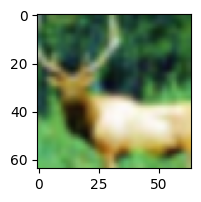

In [13]:
sample_data = next(iter(test_loader))

# Visualize the original image that is sample to test canonicalization
sample_image = invert_normalize(sample_data[0][0]).permute(1, 2, 0).numpy()

plt.figure(figsize=(2, 2))
plt.imshow(sample_image)
plt.show()

### 2. Check for canonicalization for steerable image canonicalizers



We first test it for SO(2) which is a 2D rotation group.
For this we first transform the image to k random rotations and then apply the steerable canonicalization to the image. 
We then check if the canonicalized image is the same as the original image.

In [15]:
# Transform the image using k random rotations
# number of random rotations
k = 4
# Original tensor image from the DataLoader
sample_image_tensor = sample_data[0][0]  # Assuming the first item is your image tensor

# Define an empty list to store the transformed tensor images
transformed_sample_images = []

# Get the shape of the image tensor
h, w = sample_image_tensor.shape[-2:]

# Pad the image to get rid of the black borders
pad = transforms.Pad(10, padding_mode='edge')

# crop the image to get rid of the black borders
crop = transforms.CenterCrop((h, w))
# Loop over the number of random rotations
# and transform the image tensor using torch rotation
for i in range(k):
    # Generate a random angle for rotation
    # angle = torch.rand(1).item() * 360  # Random rotation between 0 and 360 degrees
    angle = 90 * i
    
    # Pad the image to get rid of the black borders
    padded_image_tensor = pad(sample_image_tensor)
    
    # Apply the rotation to the tensor
    transformed_image_tensor = F.rotate(padded_image_tensor, angle)
    
    # Add the transformed tensor to the list
    transformed_sample_images.append(crop(transformed_image_tensor))



Function to visualize a list of image tensors.

In [14]:
def plot_image_tensors(image_tensors, titles=None, figsize=(4, 4)):
    """
    Plots a list of image tensors in a grid.

    Parameters:
    - image_tensors: List[Tensor]. A list of image tensors in (C, H, W) format.
    - titles: List[str]. Optional. A list of titles for each subplot.
    - figsize: tuple. The figure size.
    """
    # Determine the number of images
    num_images = len(image_tensors)

    # Calculate grid size for the subplots
    rows = int(torch.sqrt(torch.tensor(num_images)).item())
    cols = (num_images + rows - 1) // rows  # Ensure enough columns to display all images

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easy iteration, in case of a single row/column
    axes = axes.flatten()

    # Loop through all the images and their corresponding axes
    for i, (img_tensor, ax) in enumerate(zip(image_tensors, axes)):
        # Convert the tensor for visualization
        img_np = invert_normalize(img_tensor.squeeze()).permute(1, 2, 0).numpy()
        
        # Plot the image
        ax.imshow(img_np)
        ax.axis('off')  # Hide the axis

        # Set title if titles are provided
        if titles and i < len(titles):
            ax.set_title(titles[i])

    # If there are more axes than images, hide the extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

Visualize the transformed images

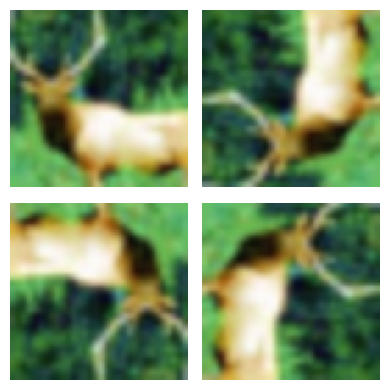

In [16]:
# Visualizing all the transformed images 
plot_image_tensors(transformed_sample_images)

Function to plot canonicalized images

In [8]:
def get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer): 
    # Set the canonicalizer to evaluation mode
    canonicalizer.eval()
    
    # Get canonicalized images for all transformed images
    with torch.no_grad():
        canonicalized_images = []
        for im in transformed_sample_images:
            im = im.unsqueeze(0).to(device)
            canonicalized_image = canonicalizer.canonicalize(im)
            canonicalized_images.append(canonicalized_image.detach().cpu())

    # Visualizing all the canonicalized images
    plot_image_tensors(canonicalized_images)

Define a steerable canonicalization network and a SteerableImageCanonicalization object.

In [9]:
# Define the hyperparameters for the canonicalization network
class CanonicalizationHyperparams:
    def __init__(self):
        self.group_type = 'rotation'
        self.input_crop_ratio = 0.9
        self.resize_shape = 64 # The shape of the image after resizing

# Create an instance of the hyperparameters
canonicalization_hyperparams = CanonicalizationHyperparams()

# Get the shape of the image
image_shape = sample_image_tensor.squeeze().shape

# Print the image shape
print(f"Image shape: {image_shape}")

# Define a steerable canonicalization network
# Note that you define any steerable network here as long as it outputs 
# a vector that steers with the input image
# This vector is used to get a rotation matrix in a differentiable manner 
canonicalization_network = ESCNNSteerableNetwork(
    in_shape = image_shape,
    out_channels=16, 
    kernel_size= 7, 
    num_layers = 2
).to(device)


# Create a steerable canonicalization object
canonicalizer = SteerableImageCanonicalization(
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=canonicalization_hyperparams,
    in_shape=image_shape,
)

Image shape: torch.Size([3, 64, 64])


Canonicalize all the transformed images and visualize the canonicalized images.

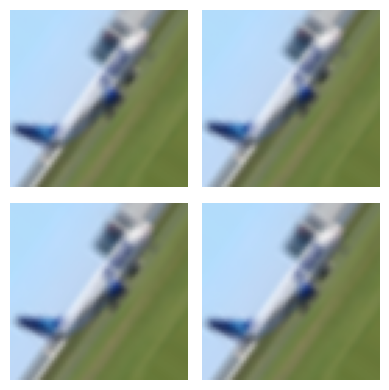

In [10]:
# Get canonicalized images for all transformed images
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

In [11]:
# Train the canonicalization network using prior regularization

# Define the optimizer
optimizer = torch.optim.Adam(canonicalization_network.parameters(), lr=0.002)

# Set the canonicalizer to training mode
canonicalizer.train()

# Set a weight for the prior regularization loss
prior_regularization_weight = 100

# Define the training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Initialize tqdm with an initial description
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    identity_metric = 0
    total_loss = 0  # To track the total loss for averaging
    
    for image, _ in train_loader_tqdm:
        # Zero the gradients
        optimizer.zero_grad()
        
        image = image.to(device)
        canonicalized_image = canonicalizer.canonicalize(image)
        
        # Get the prior regularization loss
        loss = prior_regularization_weight * canonicalizer.get_prior_regularization_loss()
        
        # Backpropagate the gradients
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update the running average of identity metric
        identity_metric += canonicalizer.get_identity_metric()

        # Update total loss for averaging
        total_loss += loss.item()

        # Update tqdm description with current loss (average loss per batch)
        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/(train_loader_tqdm.n + 1):.4f}")
    
    # Calculate and print the average loss and identity metric over the epoch
    avg_loss = total_loss / len(train_loader)
    identity_metric /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Identity Metric: {identity_metric:.4f}")   

Epoch 1/20, Loss: 71.2932: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Epoch 1/20, Average Loss: 71.2932, Identity Metric: 0.2871


Epoch 2/20, Loss: 65.9759: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 2/20, Average Loss: 65.9759, Identity Metric: 0.3402


Epoch 3/20, Loss: 66.0817: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 3/20, Average Loss: 66.0817, Identity Metric: 0.3392


Epoch 4/20, Loss: 63.9725: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Epoch 4/20, Average Loss: 63.9725, Identity Metric: 0.3603


Epoch 5/20, Loss: 63.0746: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Epoch 5/20, Average Loss: 63.0746, Identity Metric: 0.3693


Epoch 6/20, Loss: 62.4356: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Epoch 6/20, Average Loss: 62.4356, Identity Metric: 0.3756


Epoch 7/20, Loss: 62.8207: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Epoch 7/20, Average Loss: 62.8207, Identity Metric: 0.3718


Epoch 8/20, Loss: 61.8304: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Epoch 8/20, Average Loss: 61.8304, Identity Metric: 0.3817


Epoch 9/20, Loss: 62.9078: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 9/20, Average Loss: 62.9078, Identity Metric: 0.3709


Epoch 10/20, Loss: 61.3771: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


Epoch 10/20, Average Loss: 61.3771, Identity Metric: 0.3862


Epoch 11/20, Loss: 60.6954: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]


Epoch 11/20, Average Loss: 60.6954, Identity Metric: 0.3930


Epoch 12/20, Loss: 61.7512: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 12/20, Average Loss: 61.7512, Identity Metric: 0.3825


Epoch 13/20, Loss: 59.5616: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


Epoch 13/20, Average Loss: 59.5616, Identity Metric: 0.4044


Epoch 14/20, Loss: 60.7983: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 14/20, Average Loss: 60.7983, Identity Metric: 0.3920


Epoch 15/20, Loss: 59.1476: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 15/20, Average Loss: 59.1476, Identity Metric: 0.4085


Epoch 16/20, Loss: 60.3493: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]


Epoch 16/20, Average Loss: 60.3493, Identity Metric: 0.3965


Epoch 17/20, Loss: 59.0851: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Epoch 17/20, Average Loss: 59.0851, Identity Metric: 0.4091


Epoch 18/20, Loss: 58.4084: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Epoch 18/20, Average Loss: 58.4084, Identity Metric: 0.4159


Epoch 19/20, Loss: 58.4359: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Epoch 19/20, Average Loss: 58.4359, Identity Metric: 0.4156


Epoch 20/20, Loss: 58.1972: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]

Epoch 20/20, Average Loss: 58.1972, Identity Metric: 0.4180


Canonicalize all the transformed images and visualize them after prior regularization.

The canonicalization network is able to generate the canonical orientation which are in the training data distribution.

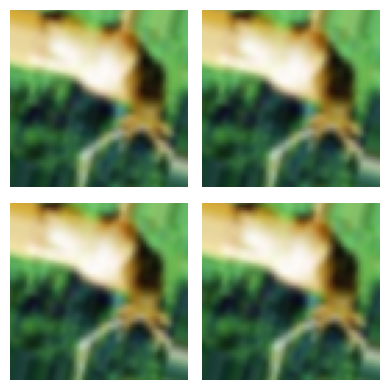

In [17]:
# Visualize the canonicalized images after training the canonicalization network using prior regularization
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

### 2. Check canonicalization using the optimization based method for continuous groups